In [1]:
# 依赖包
!pip install opencv-python numpy matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


# [基于OpenCV全景拼接（Python）SIFT/SURF](https://www.cnblogs.com/lqerio/p/11601951.html)

In [1]:
%%time
# 原始代码
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

MIN = 10
tik = time.process_time() 

# 载入图片
img1 = cv2.imread('C0123_543210.jpg') #query
img2 = cv2.imread('C0123_6789ab.jpg') #train

# 20200320091622_20200320091622_CE4_GRAS_PCAMR-C-000_SCI_N_0123_B.2BL_2.png
# 20200320091751_20200320091751_CE4_GRAS_PCAMR-C-001_SCI_N_0123_B.2BL_2.png
# 20200320091920_20200320091920_CE4_GRAS_PCAMR-C-002_SCI_N_0123_B.2BL_2.png
# 20200320092049_20200320092049_CE4_GRAS_PCAMR-C-003_SCI_N_0123_B.2BL_2.png
# 20200320092218_20200320092218_CE4_GRAS_PCAMR-C-004_SCI_N_0123_B.2BL_2.png
# 20200320092347_20200320092347_CE4_GRAS_PCAMR-C-005_SCI_N_0123_B.2BL_2.png
# 20200320092742_20200320092742_CE4_GRAS_PCAMR-C-006_SCI_N_0123_B.2BL_2.png
# 20200320092911_20200320092911_CE4_GRAS_PCAMR-C-007_SCI_N_0123_B.2BL_2.png
# 20200320093040_20200320093040_CE4_GRAS_PCAMR-C-008_SCI_N_0123_B.2BL_2.png
# 20200320093209_20200320093209_CE4_GRAS_PCAMR-C-009_SCI_N_0123_B.2BL_2.png
# 20200320093338_20200320093338_CE4_GRAS_PCAMR-C-010_SCI_N_0123_B.2BL_2.png
# 20200320093507_20200320093507_CE4_GRAS_PCAMR-C-011_SCI_N_0123_B.2BL_2.png

CPU times: user 2.09 s, sys: 904 ms, total: 3 s
Wall time: 1.64 s


In [2]:
%%time
# 初始化SIFT探测器，为什么创建SURF会报错
# 用SIFT算法找出关键点及其信息
sift=cv2.SIFT_create()
kp1,descrip1=sift.detectAndCompute(img1,None)
kp2,descrip2=sift.detectAndCompute(img2,None)

CPU times: user 20 s, sys: 2.44 s, total: 22.5 s
Wall time: 6.71 s


In [3]:
%%time
# FLANN快速匹配
FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
searchParams = dict(checks=50) # 递归遍历的次数，次数越多越准确，耗时越多
flann=cv2.FlannBasedMatcher(indexParams,searchParams)
match=flann.knnMatch(descrip1,descrip2,k=2)

CPU times: user 3min 59s, sys: 0 ns, total: 3min 59s
Wall time: 3min 59s


In [4]:
# 用Lowe算法筛取优质匹配点，0.4表示高精度匹配
good=[]
for i,(m,n) in enumerate(match):
    if(m.distance<0.75*n.distance):
        good.append(m)

print('SIFT查找关键点，精度：%.2f，点数：%d，耗时：%.2f秒' % (0.75, len(good), time.process_time()-tik))

SIFT查找关键点，精度：0.75，点数：1578，耗时：263.38秒


In [5]:
%%time
# 如果good长度大于MIN，执行后面的步骤

# 将最佳特征点在query和train下的坐标提取出来，分别保存到src_pts和ano_pts中
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
ano_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

CPU times: user 8.13 ms, sys: 2 µs, total: 8.13 ms
Wall time: 7.9 ms


(2186, 13192, 3) (1823, 6124, 3) (5469, 18372, 3)


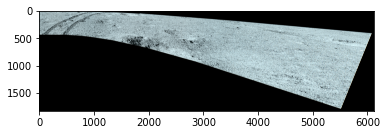

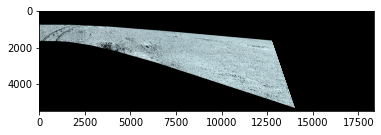

CPU times: user 5.98 s, sys: 356 ms, total: 6.34 s
Wall time: 4.33 s


(<matplotlib.image.AxesImage at 0x7f375c105b50>, None)

In [7]:
%%time
# 计算多个二维点对之间的最优单映射变换矩阵M
# 即找到一个M，使得src_pts = M * ano_pts
M,mask=cv2.findHomography(src_pts,ano_pts,cv2.RANSAC,5.0)
# 使用M，将img2进行透视变换
warpImg = cv2.warpPerspective(img2, np.linalg.inv(M), (int(img2.shape[1]*3), int(img2.shape[0]*3)))

print(img1.shape, img2.shape, warpImg.shape)
plt.imshow(img2),plt.show()
plt.imshow(warpImg),plt.show()

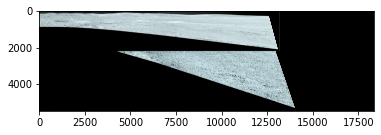

CPU times: user 3.6 s, sys: 144 ms, total: 3.74 s
Wall time: 3.74 s


(<matplotlib.image.AxesImage at 0x7f37546bce10>, None)

In [8]:
%%time
# 直接将img1覆盖到变换后的img2上，接缝部分
direct=warpImg.copy()
direct[0:img1.shape[0], 0:img1.shape[1]] =img1
plt.imshow(direct),plt.show()

逐像素融合中....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.....................................................................................

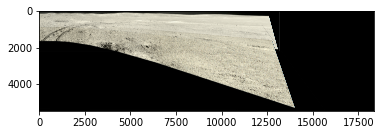

True

In [9]:
rows,cols=img1.shape[:2]
        
for col in range(0,cols):
    if img1[:, col].any() and warpImg[:, col].any():#开始重叠的最左端
        left = col
        break
for col in range(cols-1, 0, -1):
    if img1[:, col].any() and warpImg[:, col].any():#重叠的最右一列
        right = col
        break
print('逐像素融合中', end='')
k=0
res = np.zeros([rows, cols, 3], np.uint8)
for row in range(0, rows):
    if k<100:
        k=k+1
        print('.', end='')
    else:
        k=0
        print('')
    for col in range(0, cols):
        if not img1[row, col].any():#如果没有原图，用旋转的填充
            res[row, col] = warpImg[row, col]
        elif not warpImg[row, col].any():
            res[row, col] = img1[row, col]
        else:
            srcImgLen = float(abs(col - left))
            testImgLen = float(abs(col - right))
            alpha = srcImgLen / (srcImgLen + testImgLen)
            res[row, col] = np.clip(img1[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)
warpImg[0:img1.shape[0], 0:img1.shape[1]]=res
#img3=cv2.cvtColor(direct,cv2.COLOR_BGR2RGB)
#plt.imshow(img3,),plt.show()
cv2.imwrite("simplepanorma.png",direct)
img4=cv2.cvtColor(warpImg,cv2.COLOR_BGR2RGB)
plt.imshow(img4,),plt.show()
cv2.imwrite("result.png",warpImg)  

# stitch()暂不可用

封装成函数

In [1]:
def stitch(img1, img2):
    MIN = 10
    tik = time.process_time() 
    # 初始化SIFT探测器，为什么创建SURF会报错
    # 用SIFT算法找出关键点及其信息
    sift=cv2.SIFT_create()
    kp1,descrip1=sift.detectAndCompute(img1,None)
    kp2,descrip2=sift.detectAndCompute(img2,None)
    
    # FLANN快速匹配
    FLANN_INDEX_KDTREE = 0
    indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    searchParams = dict(checks=50)
    flann=cv2.FlannBasedMatcher(indexParams,searchParams)
    match=flann.knnMatch(descrip1,descrip2,k=2)
    # 用Lowe算法筛取优质匹配点，0.4表示高精度匹配
    good=[]
    for i,(m,n) in enumerate(match):
        if(m.distance<0.75*n.distance):
            good.append(m)

    print('SIFT查找关键点，精度：%.2f，点数：%d，耗时：%.2f秒' % (0.75, len(good), time.process_time()-tik))

    if len(good)>MIN:
        tik = time.process_time() 
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        ano_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        M,mask=cv2.findHomography(src_pts,ano_pts,cv2.RANSAC,5.0)
        warpImg = cv2.warpPerspective(img2, np.linalg.inv(M), (img1.shape[1]+img2.shape[1], img2.shape[0]))
        direct=warpImg.copy()
        direct[0:img1.shape[0], 0:img1.shape[1]] =img1
        simple=time.time()

        rows,cols=img1.shape[:2]
            
        for col in range(0,cols):
            if img1[:, col].any() and warpImg[:, col].any():#开始重叠的最左端
                left = col
                break
        for col in range(cols-1, 0, -1):
            if img1[:, col].any() and warpImg[:, col].any():#重叠的最右一列
                right = col
                break
        print('逐像素融合中', end='')
        k=0
        skip = 10
        res = np.zeros([rows, cols, 3], np.uint8)
        for row in range(0, rows):
            if skip != 0:
                skip = skip-1
            else:
                skip = 10
                if k<100:
                    k=k+1
                    print('.', end='')
                else:
                    k=0
                    print('')
            for col in range(0, cols):
                if not img1[row, col].any():#如果没有原图，用旋转的填充
                    res[row, col] = warpImg[row, col]
                elif not warpImg[row, col].any():
                    res[row, col] = img1[row, col]
                else:
                    srcImgLen = float(abs(col - left))
                    testImgLen = float(abs(col - right))
                    alpha = srcImgLen / (srcImgLen + testImgLen)
                    res[row, col] = np.clip(img1[row, col] * (1-alpha) + warpImg[row, col] * alpha, 0, 255)
        warpImg[0:img1.shape[0], 0:img1.shape[1]]=res
        print('逐像素融合完成，耗时：%.2f秒' % (time.process_time()-tik))

        #img3=cv2.cvtColor(direct,cv2.COLOR_BGR2RGB)
        #plt.imshow(img3,),plt.show()
        #img4=cv2.cvtColor(warpImg,cv2.COLOR_BGR2RGB)
        #plt.imshow(img4,),plt.show()
        #print("simple stich cost %f"%(simple-starttime))
        #print("\ntotal cost %f"%(final-starttime))
        #cv2.imwrite("simplepanorma.png",direct)
        cv2.imwrite("result.png",warpImg)  
    else:
        print("not enough matches!")

In [2]:
# 原始代码
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

# 载入图片
img1 = cv2.imread('png/CE4_GRAS_PCAML-C-005_SCI_N_20200329051508_20200329051508_0124_B.2BL_2.png') #left
img2 = cv2.imread('png/CE4_GRAS_PCAML-C-006_SCI_N_20200329051637_20200329051637_0124_B.2BL_2.png') #right

stitch(img1, img2)

In [5]:
# 载入图片
img1 = cv2.imread('result.png') #left
img2 = cv2.imread('CE4_GRAS_PCAML-C-002_SCI_N_20190708043636_20190708043636_0048_B_2.png') #right

stitch(img1, img2)

SIFT查找关键点，精度：0.75，点数：255，耗时：6.79秒
逐像素融合中....................................................................................................
........................................................逐像素融合完成，耗时：46.81秒
